In [2]:
import numpy as np
from common.layers import Embedding

class TimeEmbedding:
    def __init__(self, W):
        self.params =  [W]
        self.grads = [np.zeros_like(W)]
        self.layers = None
        self.W = W
        
    def forward(self, xs):
        N , T = xs.shape
        V, D = self.W.shape
        
        out = np.empty((N, T, D), dtype='f')
        self.layers = []
        
        for t in range(T):
            layer = Embedding(self.W)
            out[:, t, :] = layer.forward(xs[:, t])
            self.layers.append(layer)
            
        return out
    
    def backward(self, dout):
        N, T, D = dout.shape
        
        grad = 0
        for t in range(T):
            layer = self.layers[t]
            layer.backward(dout[:, t, :])
            grad += layer.grads[0]
            
        self.grads[0][...] = grad
        return None
    

In [ ]:
import numpy as np
from common.layers import Embedding

# 가중치 행렬 W 초기화 (어휘 크기 V=10, 임베딩 차원 D=5)
W = np.random.randn(10, 5)

# 입력 데이터 xs 초기화 (배치 크기 N=2, 타임스텝 T=3)
xs = np.array([[1, 2, 3], 
               [4, 5, 6]])

# TimeEmbedding 클래스 인스턴스 생성
time_embedding = TimeEmbedding(W)

# Forward 계산
out = time_embedding.forward(xs)
print("Forward 결과:")
print(out)

# dout 초기화 (Forward 결과와 같은 형태)
dout = np.random.randn(2, 3, 5)

# Backward 계산
time_embedding.backward(dout)
print("Backward 결과 (가중치 그래디언트):")
print(time_embedding.grads[0])

Forward 결과:
[[[ 0.60899085  0.7027235   1.094843   -0.40826038 -0.28741404]
  [-1.7422705  -0.04982123 -0.19147007 -0.3666044  -0.254397  ]
  [-0.15668114 -0.09524227 -0.1561968  -0.38497168  1.1059837 ]]

 [[-0.5317233   0.95922583 -0.45520788  0.8389329   0.3628084 ]
  [ 1.5208659  -1.3946924  -0.22357488  0.0742759  -1.4549794 ]
  [ 0.387729    0.85357547  0.41210434  0.07611932 -0.0194009 ]]]
Backward 결과 (가중치 그래디언트):
[[ 0.          0.          0.          0.          0.        ]
 [-1.28270828 -0.0240611   0.91011748 -0.61148395  1.34427949]
 [ 1.64955098  0.21007194  2.26445351  0.24983432 -0.89234993]
 [-0.21223743  0.54698686 -0.97212024  0.51907473 -0.3450605 ]
 [-0.0326278   0.19412434 -0.33340646 -1.14506982  0.94438653]
 [-0.98426656  0.23407529  1.00420555  0.32364293  0.24865409]
 [-0.6822597   0.48882526  0.6326245   1.11103934 -0.15929823]
 [ 0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.        ]
 [ 0.   

In [ ]:
class TimeAffine:
    def __init__(self, W, b):
        self.params = [W, b]
        self.grads = [np.zeros_like(W), np.zeros_like(b)]
        self.x = None
        
    def forward(self, x):
        N, T, D = x.shape
        W, b = self.params
        
        rx = x.reshape(N*T, -1)
        out = np.dot(rx, W) + b
        self.x = x
        return out.reshape(N, T, -1)
    
    def backward(self, dout):
        x = self.x
        N, T, D = x.shape
        W, b = self.params
        
        dout = dout.reshape(N*T, -1)
        rx = x.reshape(N*T, -1)
        
        db = np.sum(dout, axis=0)
        dW = np.dot(rx.T, dout)
        dx = np.dot(dout, W.T)
        dx = dx.reshape(*x.shape)
        
        self.grads[0][...] = dW
        self.grads[1][...] = db
        
        return dx

In [ ]:
from common.functions import softmax

class TimeSoftmax:
    def __init__(self):
        self.params, self.grads = [], []
        self.cache = None
        self.ignore_label = -1
        
    def forward(self, xs, ts):
        N, T, V = xs.shape
        
        if ts.ndim == 3:
            ts = ts.argmax(axis=2)
            
        mask = (ts != self.ignore_label)
        
        xs = xs.reshape(N*T, V)
        ts = ts.reshape(N*T)
        mask = mask.reshape(N*T)
        
        ys = softmax(xs)
        ls = np.log(ys[np.arange(N*T), ts])
        ls *= mask
        loss = -np.sum(ls)
        loss /= mask.sum()
        
        self.cache = (ts, ys, mask, (N, T, V))
        return loss
    
    def backward(self, dout=1):
        ts, ys, mask, (N, T, V) = self.cache
        
        dx = ys
        dx[np.arange(N*T), ts] -= 1
        dx *= dout
        dx /= mask.sum()
        dx *= mask[:, np.newaxis]
        
        dx = dx.reshape((N, T, V))
        
        return dx

말뭉치 크기: 1000, 어휘 수: 10000
| 에폭 1 | 퍼플렉서티 9393.04
| 에폭 2 | 퍼플렉서티 6446.00
| 에폭 3 | 퍼플렉서티 3482.57
| 에폭 4 | 퍼플렉서티 2211.50
| 에폭 5 | 퍼플렉서티 1754.23
| 에폭 6 | 퍼플렉서티 1411.83
| 에폭 7 | 퍼플렉서티 1281.63
| 에폭 8 | 퍼플렉서티 1155.85
| 에폭 9 | 퍼플렉서티 1053.46
| 에폭 10 | 퍼플렉서티 988.33
| 에폭 11 | 퍼플렉서티 878.04
| 에폭 12 | 퍼플렉서티 776.49
| 에폭 13 | 퍼플렉서티 732.63
| 에폭 14 | 퍼플렉서티 713.99
| 에폭 15 | 퍼플렉서티 663.59
| 에폭 16 | 퍼플렉서티 605.79
| 에폭 17 | 퍼플렉서티 571.15
| 에폭 18 | 퍼플렉서티 533.17
| 에폭 19 | 퍼플렉서티 522.98
| 에폭 20 | 퍼플렉서티 501.09
| 에폭 21 | 퍼플렉서티 469.11
| 에폭 22 | 퍼플렉서티 479.17
| 에폭 23 | 퍼플렉서티 464.20
| 에폭 24 | 퍼플렉서티 423.99
| 에폭 25 | 퍼플렉서티 413.03
| 에폭 26 | 퍼플렉서티 413.41
| 에폭 27 | 퍼플렉서티 385.44
| 에폭 28 | 퍼플렉서티 376.03
| 에폭 29 | 퍼플렉서티 384.05
| 에폭 30 | 퍼플렉서티 382.95
| 에폭 31 | 퍼플렉서티 368.18
| 에폭 32 | 퍼플렉서티 343.12
| 에폭 33 | 퍼플렉서티 338.44
| 에폭 34 | 퍼플렉서티 341.99
| 에폭 35 | 퍼플렉서티 335.57
| 에폭 36 | 퍼플렉서티 322.49
| 에폭 37 | 퍼플렉서티 309.78
| 에폭 38 | 퍼플렉서티 309.25
| 에폭 39 | 퍼플렉서티 304.40
| 에폭 40 | 퍼플렉서티 293.34
| 에폭 41 | 퍼플렉서티 297.43
| 에폭 42 | 퍼플렉서티 300.27
| 에폭 43 

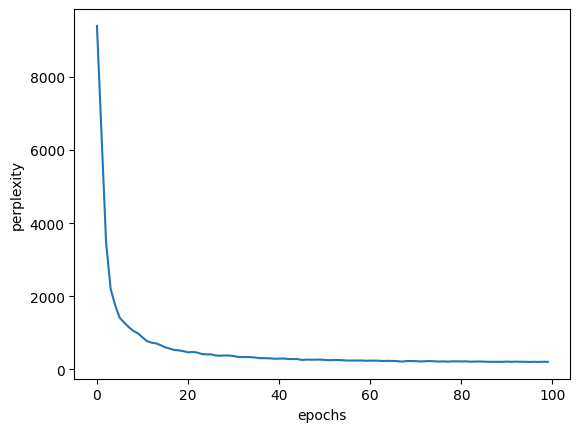

In [ ]:
import sys
sys.path.append('..')
import numpy as np
import matplotlib.pyplot as plt
from dataset import ptb
from common.optimizer import SGD
from common.trainer import RnnlmTrainer
from common.util import eval_perplexity
from simple_rnnlm import SimpleRnnlm

# 하이퍼파라미터 설정
batch_size = 20
wordvec_size = 100
hidden_size = 100
time_size = 5
lr = 0.1
max_epoch = 100

# 학습 데이터 읽기
corpus, word_to_id, id_to_word = ptb.load_data('train')
corpus_size = 1000
corpus = corpus[:corpus_size]
vocab_size = len(word_to_id)
xs = corpus[:-1]
ts = corpus[1:]

data_size = len(xs)
print('말뭉치 크기: %d, 어휘 수: %d' % (corpus_size, vocab_size))

max_iters = data_size // (batch_size * time_size)
time_idx = 0
total_loss = 0
loss_count = 0
ppl_list = []

# 모델 생성
model = SimpleRnnlm(vocab_size, wordvec_size, hidden_size)
optimizer = SGD(lr)

# 미니배치의 각 샘플의 읽기 시작 위치를 계산
jump = (corpus_size - 1) // batch_size
offsets = [i * jump for i in range(batch_size)]

for epoch in range(max_epoch):
    for iter in range(max_iters):
        # 미니배치 취득
        batch_x = np.empty((batch_size, time_size), dtype='i')
        batch_t = np.empty((batch_size, time_size), dtype='i')
        
        for t in range(time_size):
            for i, offset in enumerate(offsets):
                batch_x[i, t] = xs[(offset + time_idx) % data_size]
                batch_t[i, t] = ts[(offset + time_idx) % data_size]
            time_idx += 1
        
        
        # 기울기를 구하여 매개변수 갱신
        loss = model.forward(batch_x, batch_t)
        model.backward()
        optimizer.update(model.params, model.grads)
        total_loss += loss
        loss_count += 1
        
    # 에폭마다 퍼플렉서티 평가
    ppl = np.exp(total_loss / loss_count)
    print('| 에폭 %d | 퍼플렉서티 %.2f'% (epoch+1, ppl))
    ppl_list.append(float(ppl))
    total_loss, loss_count = 0, 0
    
x = np.arange(len(ppl_list))
plt.plot(x, ppl_list, label='train')
plt.xlabel('epochs')
plt.ylabel('perplexity')
plt.show()        
